# EECE-571M Course Project
## Modulation Classification Using Neural Networks
### Submission by Akshay Viswakumar (#32971665)

## CNN Based Solution

### 0. Acquire Data

This section is just to download the RadioML2016.10a Dataset in case it is not present in the current directory.

In [1]:
# Download the dataset from opensig

# Note: If the RML2016.10a.tar.bz2 file is in the same directory as this notebook, the file will not be downloaded again.

from pathlib import Path
dset = Path("RML2016.10a.tar.bz2")

# Check if the File Exists

if(not dset.is_file()):
    import urllib.request
    urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

In [2]:
# Decompress the RML2016.10a.tar.bz2 file into RML2016.10a.tar file

# Note: If the RML2016.10a.tar file exists, then this operation is skipped.

import sys
import os
import bz2

tarfile = Path("RML2016.10a.tar")

# Check if the Tar File Exists

if(not tarfile.is_file()):
    zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
    data = zipfile.read() # get the decompressed data
    #write the .tar file
    open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

In [3]:
# Extract the .tar file to get RML2016.10a_dict.pkl

# Note: If the RML2016.10a.tar file exists, then this operation is skipped.

import tarfile

pklFile = Path("RML2016.10a_dict.pkl")

# Check if the pkl File Exists

if(not pklFile.is_file()):
    my_tar = tarfile.open('./RML2016.10a.tar')
    my_tar.extractall('./') # specify which folder to extract to
    my_tar.close()

### 1. Extract the Pickle File and Load Dataset



In [4]:
# Extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

### 2. Import Required Packages

In [5]:
# Import Necessary Packages
%matplotlib inline
import os
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, LayerNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np

### 3. Data Pre-Processing

Split data into a training, testing and validation sets.

In [6]:
random.seed(777)     # To ensure that the dataset is split in a deterministic way.
np.random.seed(777)  # To ensure that the dataset is split in a deterministic way.

# This section of the code shuffles and splits the into Training, Testing and Validation Sets.

index = np.arange(0,220000)
random.shuffle(index)

trainIdx = index[0:110000]
testIdx = index[110000:220000]

trainX = X[trainIdx]

# Create Validation Data Set
indexVal = np.arange(0,110000)
random.shuffle(indexVal)

realTrainIdx = indexVal[0:99000] 
valIdx = indexVal[99000:110000]

# Actual Training Data
realTrainX = trainX[realTrainIdx]
X_train = np.expand_dims(realTrainX, axis=-1) # Training Set Input

# Actual Validation Data
validX = trainX[valIdx]
X_valid = np.expand_dims(validX, axis=-1) # Validation Set Input

# Actual Testing Data
testX = X[testIdx]
X_test = np.expand_dims(testX, axis=-1) # Test Set Input

# This Section of the code Prepapres labels Using One-Hot Encoding

# One Hot Encode Labels
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
ytrain=lbl_encoded[trainIdx]

# Labels for Training Data
y_train = ytrain[realTrainIdx] # Training Set Labels

# Labels for Validation Data 
y_valid = ytrain[valIdx] # Validation Set Labels

# Labels for Testing Data
y_test=lbl_encoded[testIdx] # Test Set Labels

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


### 4. CNN Based Solution

Section 4 will deal with the following 

- 4.1. Construct the CNN Model Using Keras
- 4.2. Train the model.
- 4.3. Test trained model on Test Dataset
- 4.4. Visualize Results

### 4.1 Construct the CNN Model Using Keras

In [7]:
# Network Design Parameters

# Network Parameters
dropoutRate = 0.5

# Structure
inpShape = (2,128,1) # Shape of Input Data
CNN1_numFilt = 512 # Number of Filters in CNN Layer 1
CNN1_kernSize = (1,3) # Kernel Size of CNN Layer 1

CNN2_numFilt = 256 # Number of Filters in CNN Layer 2
CNN2_kernSize = (1,3) # Kernel Size of CNN Layer 2

CNN3_numFilt = 128 # Number of Filters in CNN Layer 3
CNN3_kernSize = (1,3) # Kernel Size of CNN Layer 3

CNN4_numFilt = 64 # Number of Filters in CNN Layer 4
CNN4_kernSize = (1,3) # Kernel Size of CNN Layer 4

Dense1_numNeurons = 128 # Number of Nodes in the First Fully Connected Layer
numOutput = 11 # Number of Output Nodes

# Activation Functions
activationHidden = 'relu'
activationOutput = 'softmax'

# Loss Function
lossFunction = 'categorical_crossentropy'

# Learning Algorithm
netOptimizer = 'adam'

# Callbacks
callbackList = [
        tensorflow.keras.callbacks.ModelCheckpoint('CNN-Weights_best.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')]

# Construct Network
model = models.Sequential()
model.add(Convolution2D(filters=CNN1_numFilt, kernel_size=CNN1_kernSize,input_shape=inpShape, padding='same', activation=activationHidden, name='Conv_1'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=CNN2_numFilt, kernel_size=CNN2_kernSize,padding='same', activation=activationHidden, name='Conv_2'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=CNN3_numFilt, kernel_size=CNN3_kernSize,padding='same', activation=activationHidden, name='Conv_3'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Convolution2D(filters=CNN4_numFilt, kernel_size=CNN4_kernSize,padding='same', activation=activationHidden, name='Conv_4'))
model.add(MaxPooling2D(pool_size=(1,2),padding='same'))
model.add(Dropout(dropoutRate))

model.add(Flatten())
model.add(Dense(Dense1_numNeurons, activation=activationHidden))
model.add(Dense(numOutput, activation=activationOutput))
model.compile(loss=lossFunction, optimizer=netOptimizer,metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 2, 128, 512)       2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 64, 512)        0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 64, 512)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 2, 64, 256)        393472    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 32, 256)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 32, 256)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 2, 32, 128)        9

### 4.3 Train CNN Model

In [8]:
# Train Model
history = model.fit(X_train,y_train,epochs=100,batch_size=1024,validation_data=(X_valid,y_valid),callbacks=callbackList,verbose=2)

Train on 99000 samples, validate on 11000 samples
Epoch 1/100
99000/99000 - 47s - loss: 2.3617 - categorical_accuracy: 0.1129 - val_loss: 2.2126 - val_categorical_accuracy: 0.1665
Epoch 2/100
99000/99000 - 35s - loss: 1.9097 - categorical_accuracy: 0.2802 - val_loss: 1.6952 - val_categorical_accuracy: 0.3581
Epoch 3/100
99000/99000 - 35s - loss: 1.6499 - categorical_accuracy: 0.3734 - val_loss: 1.5639 - val_categorical_accuracy: 0.4116
Epoch 4/100
99000/99000 - 35s - loss: 1.5647 - categorical_accuracy: 0.4118 - val_loss: 1.5074 - val_categorical_accuracy: 0.4350
Epoch 5/100
99000/99000 - 35s - loss: 1.5157 - categorical_accuracy: 0.4283 - val_loss: 1.4576 - val_categorical_accuracy: 0.4539
Epoch 6/100
99000/99000 - 35s - loss: 1.4816 - categorical_accuracy: 0.4430 - val_loss: 1.4442 - val_categorical_accuracy: 0.4590
Epoch 7/100
99000/99000 - 35s - loss: 1.4538 - categorical_accuracy: 0.4524 - val_loss: 1.4627 - val_categorical_accuracy: 0.4455
Epoch 8/100
99000/99000 - 35s - loss: 1.

In [9]:
# Backup History for Plotting Outputs

np_loss_history = np.array(history.history["loss"])
np.save('CNN-lossHist.npy',np_loss_history)

np_accu_history = np.array(history.history["categorical_accuracy"])
np.save('CNN-accuHist.npy',np_accu_history)

np_val_loss_history = np.array(history.history["val_loss"])
np.save('CNN-valLossHist.npy',np_val_loss_history)

np_val_accu_history = np.array(history.history["val_categorical_accuracy"])
np.save('CNN-valAccuHist.npy',np_val_accu_history)

#### Code Block Below Plots the Loss and Accuracy Curves For Training and Validation Sets

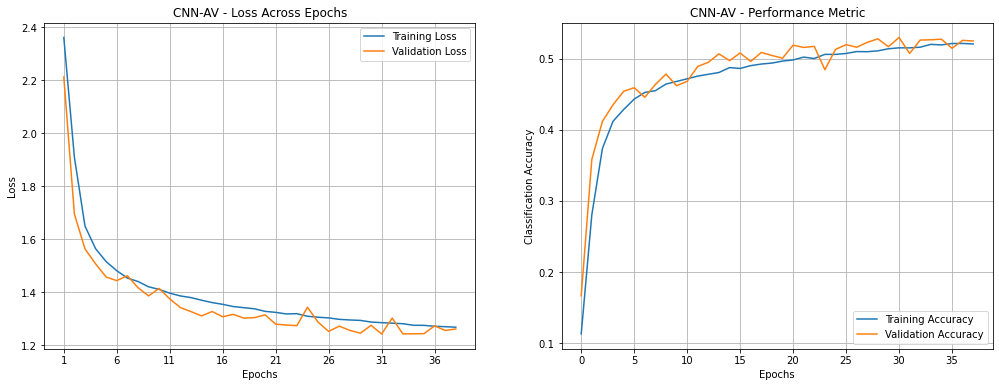

In [10]:
# Plots The Loss and Acuracy Curves from Testing
# Load Recently Backed-Up Details of History
lHistCNN = np.load('CNN-lossHist.npy')
aHistCNN = np.load('CNN-accuHist.npy')

vLHistCNN = np.load('CNN-valLossHist.npy')
vAHistCNN = np.load('CNN-valAccuHist.npy')

# Show loss curves 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(17, 6))
ax1.set_title('CNN-AV - Loss Across Epochs')
ax1.plot(lHistCNN, label='Training Loss')
ax1.plot(vLHistCNN, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_xticks(np.arange(0,len(lHistCNN)+1,5), minor=False)
ax1.set_xticklabels(np.arange(1,len(lHistCNN)+1,5), fontdict=None, minor=False)
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
               
ax2.set_title('CNN-AV - Performance Metric')
ax2.plot(aHistCNN, label='Training Accuracy')
ax2.plot(vAHistCNN, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_xticks(np.arange(0,len(lHistCNN),5), minor=False)
ax2.set_xticklabels(np.arange(0,len(lHistCNN),5), fontdict=None, minor=False)
ax2.set_ylabel('Classification Accuracy')
ax2.grid()
ax2.legend(loc='lower right')

### 4.4 Run CNN Model on Testing Dataset

During training, the weights yielding the least validation loss have been stored. This is reloaded into the model before we evaluate the network performance using the test dataset.

In [11]:
# Re-load Best Weights from Training
model.load_weights('CNN-Weights_best.h5')

# Evaluate Test Dataset Using Trained DNN Model
model.evaluate(X_test,y_test)

110000/110000 [==============================] - 18s 160us/sample - loss: 1.2447 - categorical_accuracy: 0.5264


[1.2446652878327804, 0.5264182]

### 4.5 Visualize Results

In [12]:
# Helper Functions to Plot Confusion Matrix

# Function to Extract Test Data of Specific SNR
def extractTest(data,labels,labelsEncoded,testIndex,snr):
    testData = data[testIndex]
    labelArray = np.array([labels])
    testLabels = labelArray[:,testIdx,:]
    testLabelsEncoded = labelsEncoded[testIdx]
    
    idxOP = list()
    
    # Loop Through Label Array To Get Index of Specific SNR
    for i in range(0,testLabels.shape[1]):
        if testLabels[0,i,1].decode('ascii')==snr:
            idxOP.append(i)
    
    # Return Subset of Test Data and Corresponding Labels
    opTestData = np.expand_dims(testData[idxOP,:,:],axis=-1)
    opTestLabel = testLabelsEncoded[idxOP]
    
    return opTestData, opTestLabel

def plot_confusion_matrix(cm, titleAdd, title='CNN-AV Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+titleAdd)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix Function
def prepConfMat(testData,testLabel,predTestLabel,mods,title):
    modString = list()
    for i in range(0,len(mods)):
        modString.append(mods[i].decode('ascii'))
    
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,testData.shape[0]):
        j = list(testLabel[i,:]).index(1)
        k = int(np.argmax(predTestLabel[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plot_confusion_matrix(confnorm, title, labels=modString)

#### Plot Confusion Matrix for All SNRs

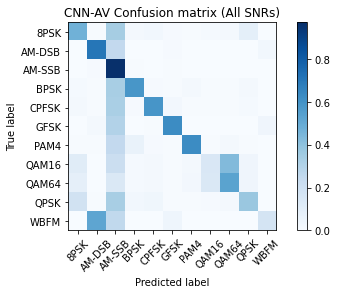

In [13]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=1024)

prepConfMat(X_test,y_test,test_Y_hat,mods,' (All SNRs)')

#### Plot Confusion Matrix for Specific SNRs

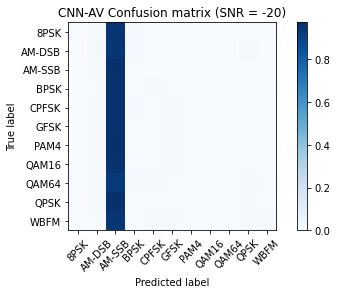

In [14]:
# SNR Value Can be Changed to View Confusion Matrix at another SNR
snr = '-20' 
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

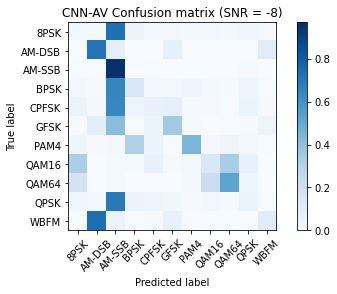

In [15]:
# SNR Value Can be Changed to View Confusion Matrix at another SNR
snr = '-8'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

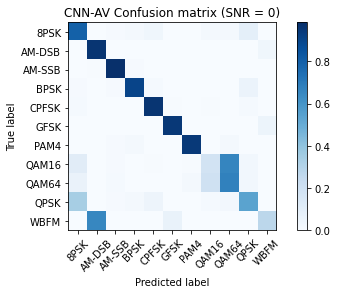

In [16]:
# SNR Value Can be Changed to View Confusion Matrix at another SNR
snr = '0'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

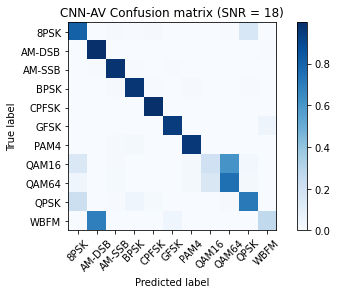

In [17]:
# SNR Value Can be Changed to View Confusion Matrix at another SNR
snr = '18'
title = ' (SNR = '+snr+')'
x_testSNR, y_TestSNR = extractTest(X,lbl,lbl_encoded,testIdx,snr)
y_hat_snr = model.predict(x_testSNR, batch_size=1024)
prepConfMat(x_testSNR,y_TestSNR,y_hat_snr,mods,title)

### Print and Plot Average Accuracy Across All Classes For Each SNR 

Overall Accuracy:  0.096593980897459 for SNR b'-20'
Overall Accuracy:  0.09477124183006536 for SNR b'-18'
Overall Accuracy:  0.09109200658496433 for SNR b'-16'
Overall Accuracy:  0.10836363636363637 for SNR b'-14'
Overall Accuracy:  0.1472756698435533 for SNR b'-12'
Overall Accuracy:  0.20881542699724517 for SNR b'-10'
Overall Accuracy:  0.3202911737943585 for SNR b'-8'
Overall Accuracy:  0.4719424460431655 for SNR b'-6'
Overall Accuracy:  0.5875892366831411 for SNR b'-4'
Overall Accuracy:  0.6868314275175212 for SNR b'-2'
Overall Accuracy:  0.7417146974063401 for SNR b'0'
Overall Accuracy:  0.7708677306916162 for SNR b'2'
Overall Accuracy:  0.7729632945389436 for SNR b'4'
Overall Accuracy:  0.776057605760576 for SNR b'6'
Overall Accuracy:  0.7778810408921933 for SNR b'8'
Overall Accuracy:  0.7808144796380091 for SNR b'10'
Overall Accuracy:  0.7761139517896275 for SNR b'12'
Overall Accuracy:  0.7810205580029369 for SNR b'14'
Overall Accuracy:  0.7659148781375046 for SNR b'16'
Overall A

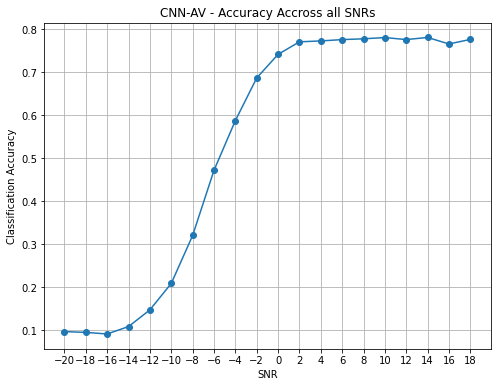

In [18]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[testIdx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

# Show loss curves 
plt.figure(figsize=(8, 6))
plt.title('CNN-AV - Accuracy Accross all SNRs')
plt.plot(np.arange(-20,20,2), acc_array,marker='.',markersize=12)
plt.xlabel('SNR')
plt.xticks(np.arange(-20,20,2))
plt.ylabel('Classification Accuracy')
plt.grid()
plt.show()